In [1]:
import sys
import os
import pathlib
import glob
import random
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from dateutil import parser
# from datetime import datetime, timedelta
import sweetviz as sv

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from flexitext import flexitext

In [2]:
%load_ext autoreload
%autoreload 2

from helper_functions import epa_taiwan_data_pipeline, visualization

In [4]:
root_dir = pathlib.Path(os.getcwd()).parent
raw_data_dir = root_dir / "data/0_raw"
processed_data_dir = root_dir / "data/1_processed"
experiment_dir = root_dir / "experiment"

# Data Loading and Preprocessing

In [5]:
# Import the data
raw_klhk_jkt_dir = raw_data_dir / "klhk_jkt"
klhk_jkt_list = glob.glob(f'{str(raw_klhk_jkt_dir)}/*.xlsx')

In [23]:
raw_df = pd.concat([pd.read_excel(file) for file in klhk_jkt_list])
raw_df.head(2)

,Stasiun,Tanggal,Waktu,PM10,PM2.5,SO2,CO,O3,NO2,HC,PM 2.5 Sedang,PM 2.5 Tidak Sehat
0,Bantar Gebang,2023-06-01,00:00:00,93.0,131.0,0.0,22,12.0,9.0,0.0,55.4,150.4
1,Bantar Gebang,2023-06-01,01:00:00,91.0,129.0,0.0,22,12.0,9.0,0.0,55.4,150.4


In [ ]:
my_report = sv.analyze(raw_df)
my_report.show_notebook()

In [25]:
# standardize column names
col_name_mapping = {_: _.lower() for _ in raw_df.columns}
processed_df = raw_df.copy()
processed_df = processed_df.rename(columns=col_name_mapping)

# create read_time column as datetime
processed_df['read_time'] = pd.to_datetime(processed_df['tanggal'].astype("str") + ' ' + processed_df['waktu'])
processed_df.drop(['tanggal', 'waktu'], axis=1, inplace=True)

# there's "x" value in "co" column
processed_df['co'] = pd.to_numeric(processed_df['co'], errors='coerce')

# impute null values
# pm10, pm2.5, so2, co, o3, no2, hc
# https://drnesr.medium.com/filling-gaps-of-a-time-series-using-python-d4bfddd8c460
# https://www.section.io/engineering-education/missing-values-in-time-series/


In [27]:
processed_df.head(2)

,stasiun,pm10,pm2.5,so2,co,o3,no2,hc,pm 2.5 sedang,pm 2.5 tidak sehat,read_time
0,Bantar Gebang,93.0,131.0,0.0,22.0,12.0,9.0,0.0,55.4,150.4,2023-06-01 00:00:00
1,Bantar Gebang,91.0,129.0,0.0,22.0,12.0,9.0,0.0,55.4,150.4,2023-06-01 01:00:00


d:\0_amri_local\11_aqi_forecast\notebooks\helper_functions\visualization.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df[lagged_param_name] = temp_df[parameter].shift(shift)


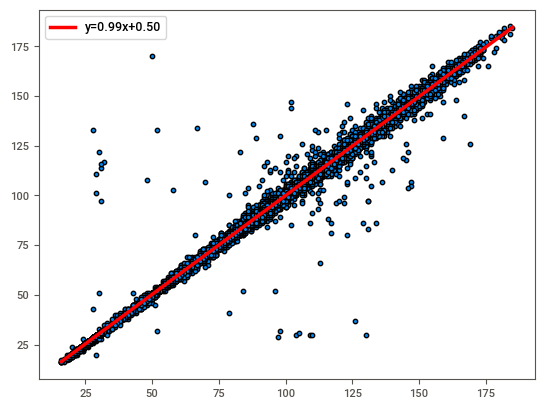

In [31]:
visualization.plot_lagged_scatter(
    processed_df,
    visualization.reg_line,
)

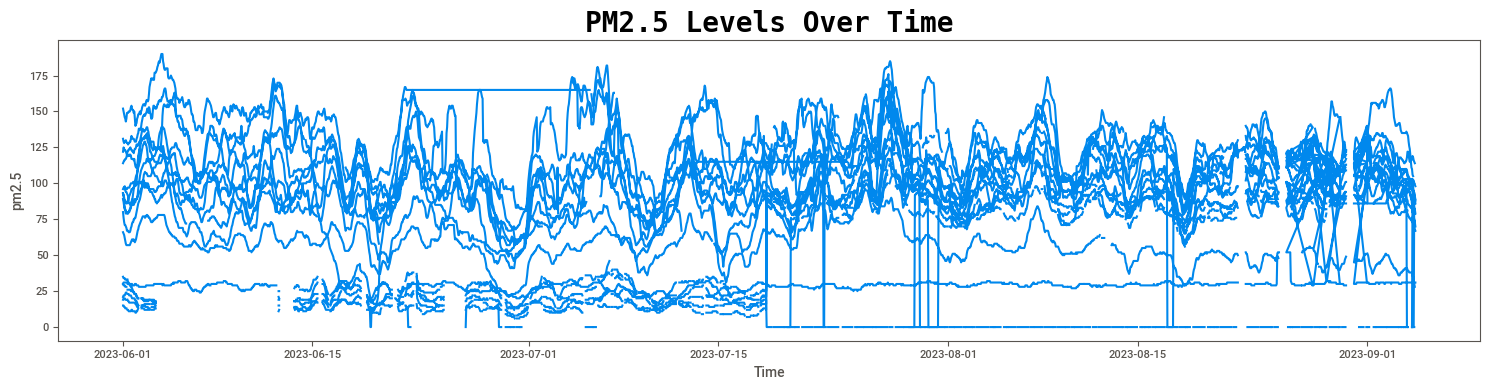

In [32]:
# col_to_plot = processed_df.columns[1:-1]
col_to_plot = ["pm2.5"]

nrow = len(col_to_plot)
ncols = 1

fig, ax = plt.subplots(
    nrow,
    ncols,
    figsize = (15,4*nrow)
    )

try:
    for col, ax in zip(col_to_plot, ax.flatten()):
        ax.plot(
            processed_df['read_time'],
            processed_df[col],
            linestyle='-',
            )
        ax.set_title(f'{col.upper()} Levels Over Time', fontweight = "bold", fontsize = 20, fontfamily = "monospace")
        ax.set_xlabel('Time')
        ax.set_ylabel(f'{col}')
except:
    ax.plot(
        processed_df['read_time'],
        processed_df[col_to_plot[0]],
        linestyle='-',
        )
    ax.set_title(f'{col_to_plot[0].upper()} Levels Over Time', fontweight = "bold", fontsize = 20, fontfamily = "monospace")
    ax.set_xlabel('Time')
    ax.set_ylabel(f'{col_to_plot[0]}')

plt.tight_layout()